# Start cluster and import aux functions

In [1]:
import h2o
import aux_functions as af

h2o.init(max_mem_size='10G', min_mem_size='7G')
raw_data = h2o.import_file("/Users/donny.ho/AnacondaProjects/churn_model_poc/Churn_Modelling.csv", sep=';')
path = '/Users/donny.ho/AnacondaProjects/churn_model_poc/saved_h20_models'

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 hours 34 mins
H2O cluster version:,3.10.4.8
H2O cluster version age:,6 months and 13 days !!!
H2O cluster name:,H2O_from_python_donny_ho_pdbvc6
H2O cluster total nodes:,1
H2O cluster free memory:,8.72 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%


# Clean data

In [8]:
columns_to_keep = ['Geography','Gender','HasCrCard','IsActiveMember','Exited']
columns_to_drop = ['RowNumber','CustomerId','Surname']
columns_to_scale = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

cleaned_data,train, valid, test,training_columns,response_column = af.clean_data(data_frame=raw_data,
                                                                              to_keep=columns_to_keep,
                                                                              to_drop=columns_to_drop,
                                                                              to_scale=columns_to_scale,
                                                                              normalize = False)


CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
619,France,Female,42,2,0,1,1,1,101349,1
608,Spain,Female,41,1,83807.9,1,0,1,112543,0
502,France,Female,42,8,159661,3,1,0,113932,1
699,France,Female,39,1,0,2,0,0,93826.6,0
850,Spain,Female,43,2,125511,1,1,1,79084.1,0
645,Spain,Male,44,8,113756,2,1,0,149757,1
822,France,Male,50,7,0,2,1,1,10062.8,0
376,Germany,Female,29,4,115047,4,1,0,119347,1
501,France,Male,44,4,142051,2,0,1,74940.5,0
684,France,Male,27,2,134604,1,1,1,71725.7,0


### Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b85f850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1c4bb8d0>]], dtype=object)

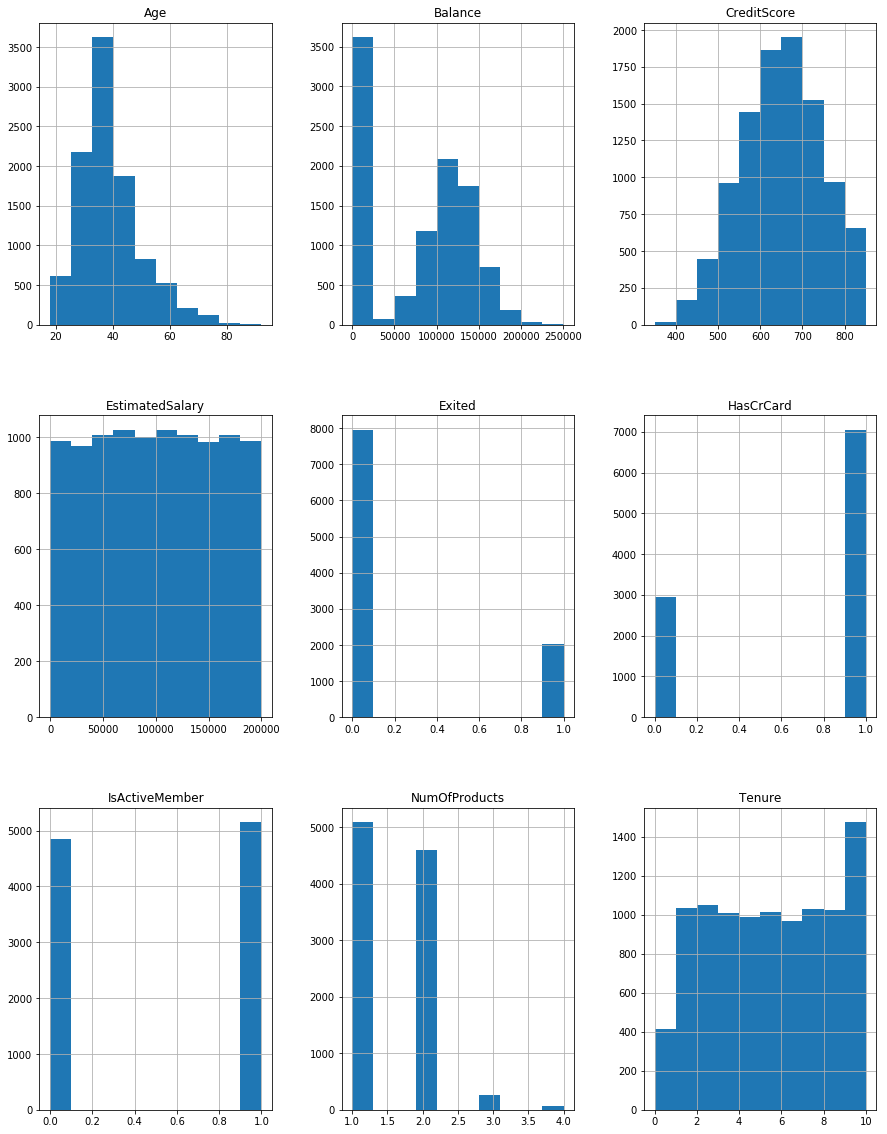

In [19]:
%matplotlib inline
cleaned_data.as_data_frame().hist(layout=(3,3),
                                  figsize = (15,20),
                                 )

### Scatter Matrix

/Users/donny.ho/anaconda3/envs/churn_model_27/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  # This is added back by InteractiveShellApp.init_path()


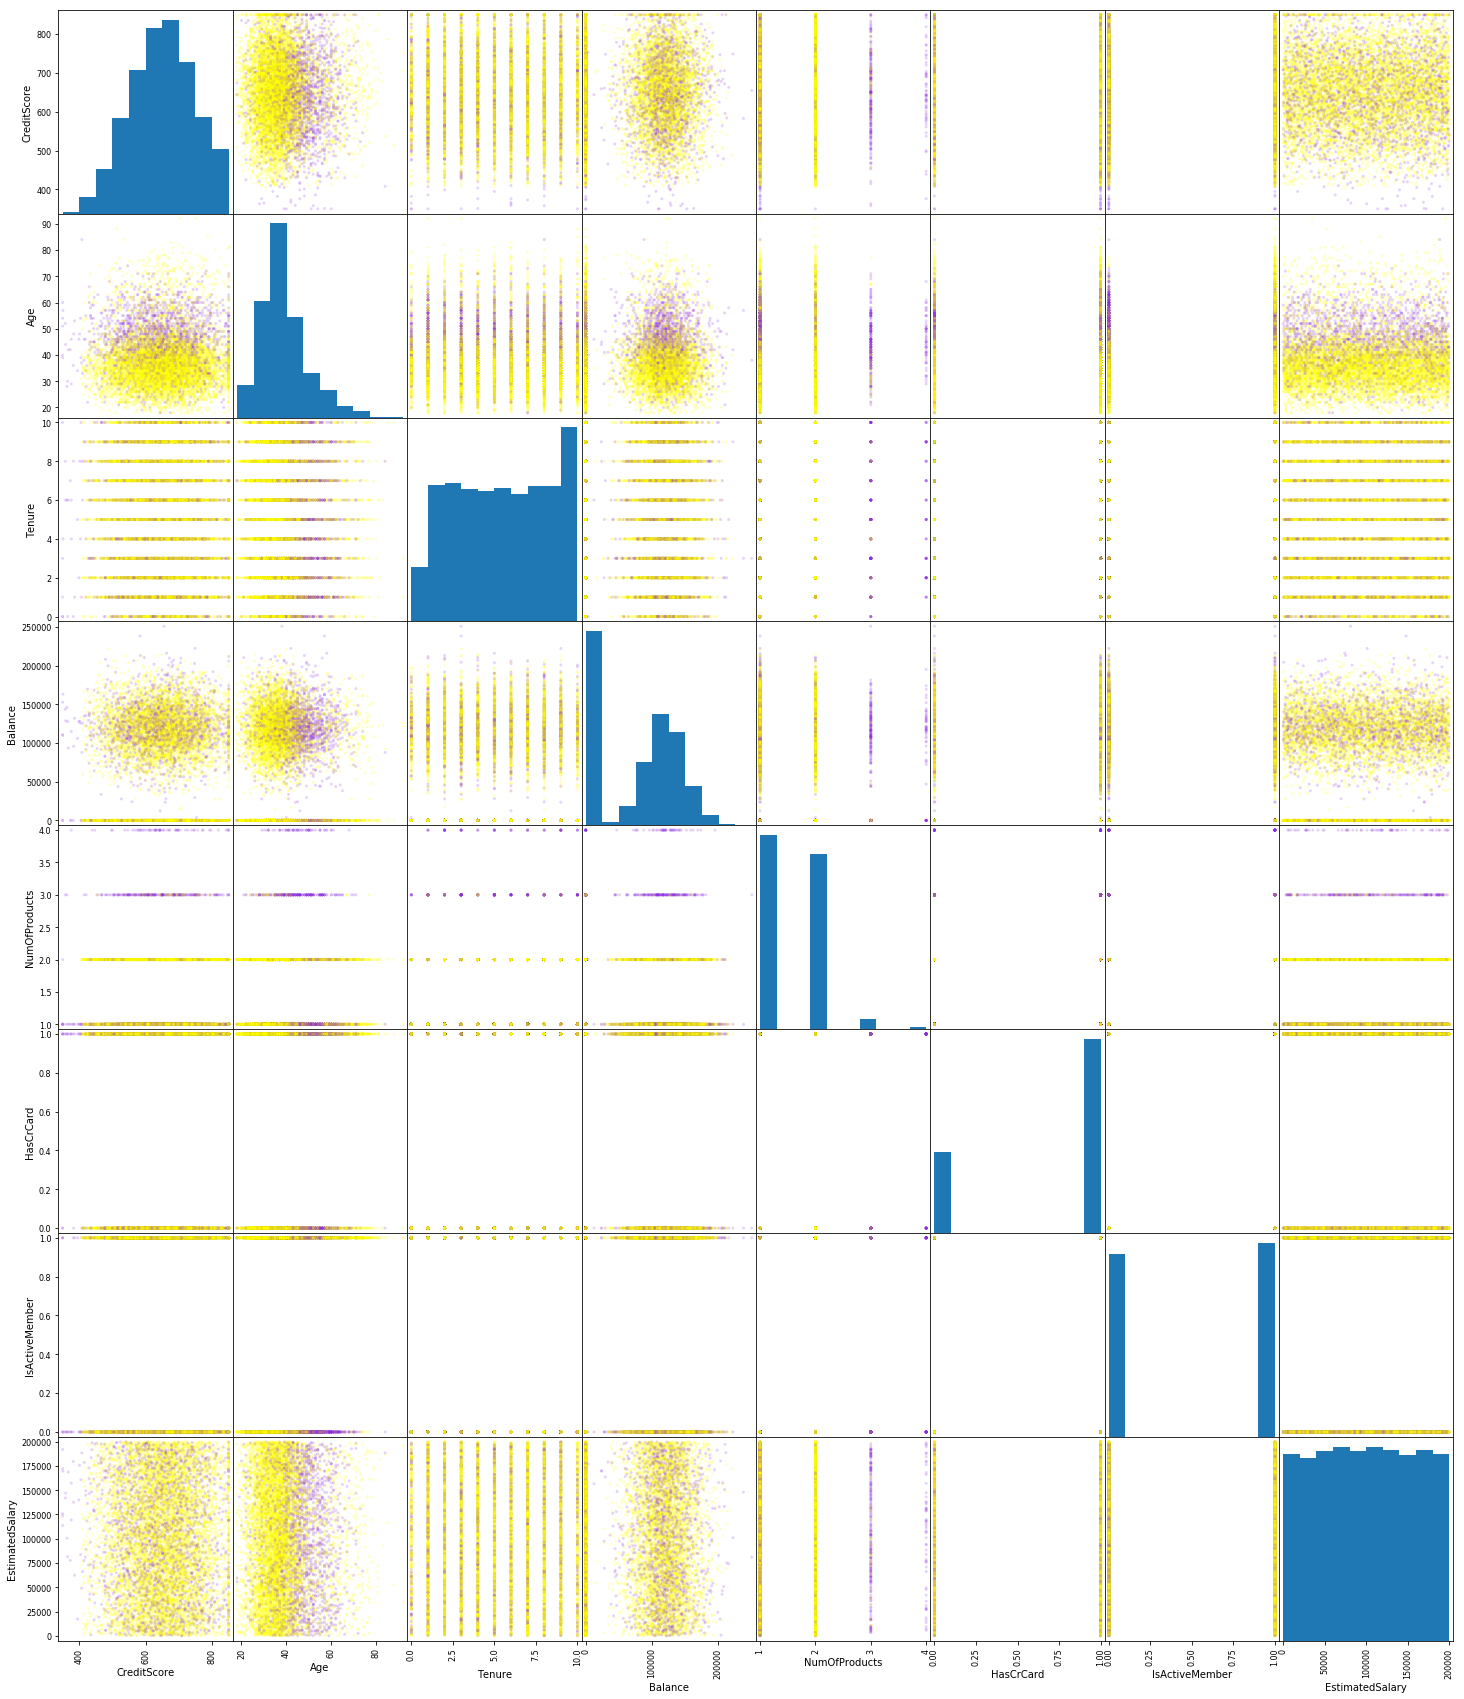

In [24]:
from pandas.tools.plotting import scatter_matrix
import pandas as pd
# define colors list, to be used to plot survived either red (=0) or green (=1)
colors=['yellow','blueviolet']


spm = pd.tools.plotting.scatter_matrix(cleaned_data[:-1].as_data_frame(use_pandas=True), 
                                       alpha=0.2, 
                                       figsize=(25, 30),
                                       c=cleaned_data.as_data_frame(use_pandas=True).Exited.apply(lambda x:colors[x]),
                                       diagonal='hist'
                                      )

# Random Forrest

In [9]:
train_rf = af.upsample(data_frame=train_glm,to_keep=columns_to_keep, minority_to_majority_ratio=1)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
rf = h2o.load_model(path+'/rf')

In [10]:
from h2o.estimators import H2ORandomForestEstimator

model_id="rf"

rf = H2ORandomForestEstimator(
    model_id                          = model_id,
    nfolds                            = 10,
    ntrees                            = 500,
    max_depth                         = 10,
    stopping_rounds                   = 0,
    stopping_tolerance                = 0.01,
    score_each_iteration              = True,
    fold_assignment                   = "Modulo",
    keep_cross_validation_predictions = True,
    stopping_metric                   = 'auc',
    seed                              = 3000000
)

rf.train(x=training_columns, y=response_column, training_frame=train_rf, validation_frame=valid)

h2o.save_model(model=rf, 
               path=path,
               force=True)

drf Model Build progress: |███████████████████████████████████████████████| 100%


u'/Users/donny.ho/AnacondaProjects/churn_model_poc/saved_h20_models/rf'

# GBM

In [5]:
rf = h2o.load_model(path+'/gbm')

In [ ]:
#from h2o.estimators.gbm import H2OGradientBoostingEstimator
#
#model_id="gbm"
#
#gbm = H2OGradientBoostingEstimator(
#        distribution                      = 'AUTO',
#        model_id                          = model_id,
#        learn_rate                        = 0.25,
#        ntrees                            = 450,
#        max_depth                         = 20,
#        stopping_tolerance                = 0.01,
#        stopping_rounds                   = 2,
#        score_each_iteration              = True,
#        nfolds                            = 10,
#        fold_assignment                   = "Modulo",
#        keep_cross_validation_predictions = True,
#        stopping_metric                   ='auc',
#        seed                              = 3000000
#    )
#gbm.train(x=training_columns, y=response_column, training_frame=train,validation_frame=valid)
#h2o.save_model(model=gbm, path=path, force=True)


# GLM 

In [6]:
#cleaned_data_glm, train_glm, valid_glm, test_glm, training_columns, response_column = af.clean_data(data_frame=raw_data, 
#                                                                                                 to_keep=columns_to_keep, 
#                                                                                                 to_drop=columns_to_drop, 
#                                                                                                 to_scale=columns_to_scale, 
#                                                                                                 normalize = True)

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Up-sampling training data for GLM

In [5]:
train_glm = af.upsample(data_frame=train_glm,to_keep=columns_to_keep, minority_to_majority_ratio=1)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
glm = h2o.load_model(path+'/glm')

In [ ]:
#from h2o.estimators.glm import H2OGeneralizedLinearEstimator
#model_id="glm"
#
#glm = H2OGeneralizedLinearEstimator(
#    model_id                          = model_id,
#    family                            = 'binomial',
#    lambda_search                     = True,
#    score_each_iteration              = True,
#    nfolds                            = 10,
#    fold_assignment                   = "Modulo",
#    keep_cross_validation_predictions = True,
#    seed                              = 3000000
#)
#
#glm.train(x=training_columns, y=response_column, training_frame=train_glm,validation_frame=valid_glm)
#h2o.save_model(model=glm, path=path ,force=True)
#

# Ensemble model

In [ ]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

#all_model_ids.extend(grid_search_glm.model_ids)
ensemble = H2OStackedEnsembleEstimator( 
    base_models = ['rf','gbm']#all_model_ids
                                      )
ensemble.train(x=training_columns, 
               y=response_column,
               training_frame=train,
               validation_frame=valid
                )

# ROC curve

### Ensemble

In [ ]:
roc_plot(ensemble)

### Random Forest

In [ ]:
roc_plot(rf)

### GBM

In [ ]:
roc_plot(gbm)

### Logistic regression

glm prediction progress: |████████████████████████████████████████████████| 100%


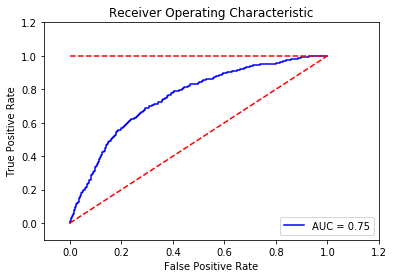

In [9]:
af.roc_plot(glm,test_frame=test_glm)

# Cut-off vs Accurcy, Precision and Recall

In [ ]:
cut_off_plot(ensemble)

In [ ]:
cut_off_plot(rf)

In [ ]:
cut_off_plot(gbm)

In [ ]:
cut_off_plot(glm)

In [ ]:
confusion_matrix(data_frame=test,model=rf,cutoff=0.5)

In [ ]:
confusion_matrix(data_frame=test,model=gbm,cutoff=0.5)

In [ ]:
confusion_matrix(data_frame=test,model=ensemble,cutoff=0.5)

In [ ]:
confusion_matrix(data_frame=test,model=glm,cutoff=0.5)